<a href="https://www.kaggle.com/code/asad1212/100-sports-image-classification?scriptVersionId=204803899" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
import os
import shutil
import random

# Define paths for the original dataset and output directories
input_base_dir = '/kaggle/input/sports-classification'  # Update YOUR_DATASET_NAME
working_dir = '/kaggle/working'
merged_dir = os.path.join(working_dir, 'sports-classification-merged')  # Temp directory for merging all classes
final_base_dir = os.path.join(working_dir, 'sports-classification')  # Final directory for train, valid, test

# Step 1: Create merged and final directories
os.makedirs(merged_dir, exist_ok=True)
for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(final_base_dir, split), exist_ok=True)

# Step 2: Merge train, test, and val folders into "sports-classification-merged"
for split in ['train', 'test', 'valid']:  # Original folder names
    split_dir = os.path.join(input_base_dir, split)
    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        merged_class_dir = os.path.join(merged_dir, class_name)
        os.makedirs(merged_class_dir, exist_ok=True)

        # Copy images to merged directory
        for img_name in os.listdir(class_dir):
            shutil.copy(os.path.join(class_dir, img_name), merged_class_dir)

# Step 3: Shuffle and split images in "sports-classification-merged"
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15

# Split images for each class in merged directory
for class_name in os.listdir(merged_dir):
    class_dir = os.path.join(merged_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    # Calculate split indices
    train_end = int(len(images) * train_ratio)
    valid_end = train_end + int(len(images) * valid_ratio)

    # Assign images to train, valid, and test
    splits = {
        'train': images[:train_end],
        'valid': images[train_end:valid_end],
        'test': images[valid_end:]
    }

    # Copy images into final directories
    for split, img_list in splits.items():
        split_class_dir = os.path.join(final_base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_name in img_list:
            shutil.copy(os.path.join(class_dir, img_name), split_class_dir)

print("Dataset restructuring complete! Check /kaggle/working/sports-classification for train, valid, and test folders.")


Dataset restructuring complete! Check /kaggle/working/sports-classification for train, valid, and test folders.


## Plotting Image

In [3]:
def display_images(loader, class_names, num_images=100):
    images_shown = 0
    plt.figure(figsize=(20, 20))
    
    for inputs, labels in loader:
        batch_size = inputs.size(0)
        
        for i in range(batch_size):
            if images_shown >= num_images:
                plt.show()  # Display the figure when we've collected enough images
                return
            
            image = inputs[i]
            label = labels[i].item()  # Get the label index
            image = image.permute(1, 2, 0)  # Rearrange dimensions for display (C, H, W) -> (H, W, C)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
            
            plt.subplot(10, 10, images_shown + 1)  # Display in a 10x10 grid
            plt.imshow(image.clip(0, 1))  # Clip to valid range
            plt.title(class_names[label])
            plt.axis('off')
            
            images_shown += 1

## Plot Results

In [4]:
def show_results(results):
    train_acc, train_loss, val_acc, val_loss = results
    
    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy over Epochs")

    plt.show()
    

## Set Device

Set the device to GPU if available, otherwise use CPU

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Dataset

### 1. Paths

In [6]:
train_path = '/kaggle/working/sports-classification/train'
test_path = '/kaggle/working/sports-classification/valid'
val_path = '/kaggle/working/sports-classification/test'

### 2. Transformation
       Make the data right for the model.

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### 3. Load Train, Val and Test Data

In [8]:
train_data = ImageFolder(root = train_path, transform = train_transforms)
val_data = ImageFolder(root = val_path, transform = val_transforms)
test_data = ImageFolder(root = test_path, transform = val_transforms)

### 4. Create DataLoaders

In [9]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset = val_data, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)
test_loader = DataLoader(dataset = test_data, batch_size = 32, shuffle = False, num_workers=4, pin_memory=True)

### 5. See Number Of Classes

In [10]:
num_classes = len(train_data.classes)
print('Total Number of classes in Dataset :', num_classes)

Total Number of classes in Dataset : 100


### 6. Plot Some of the classes

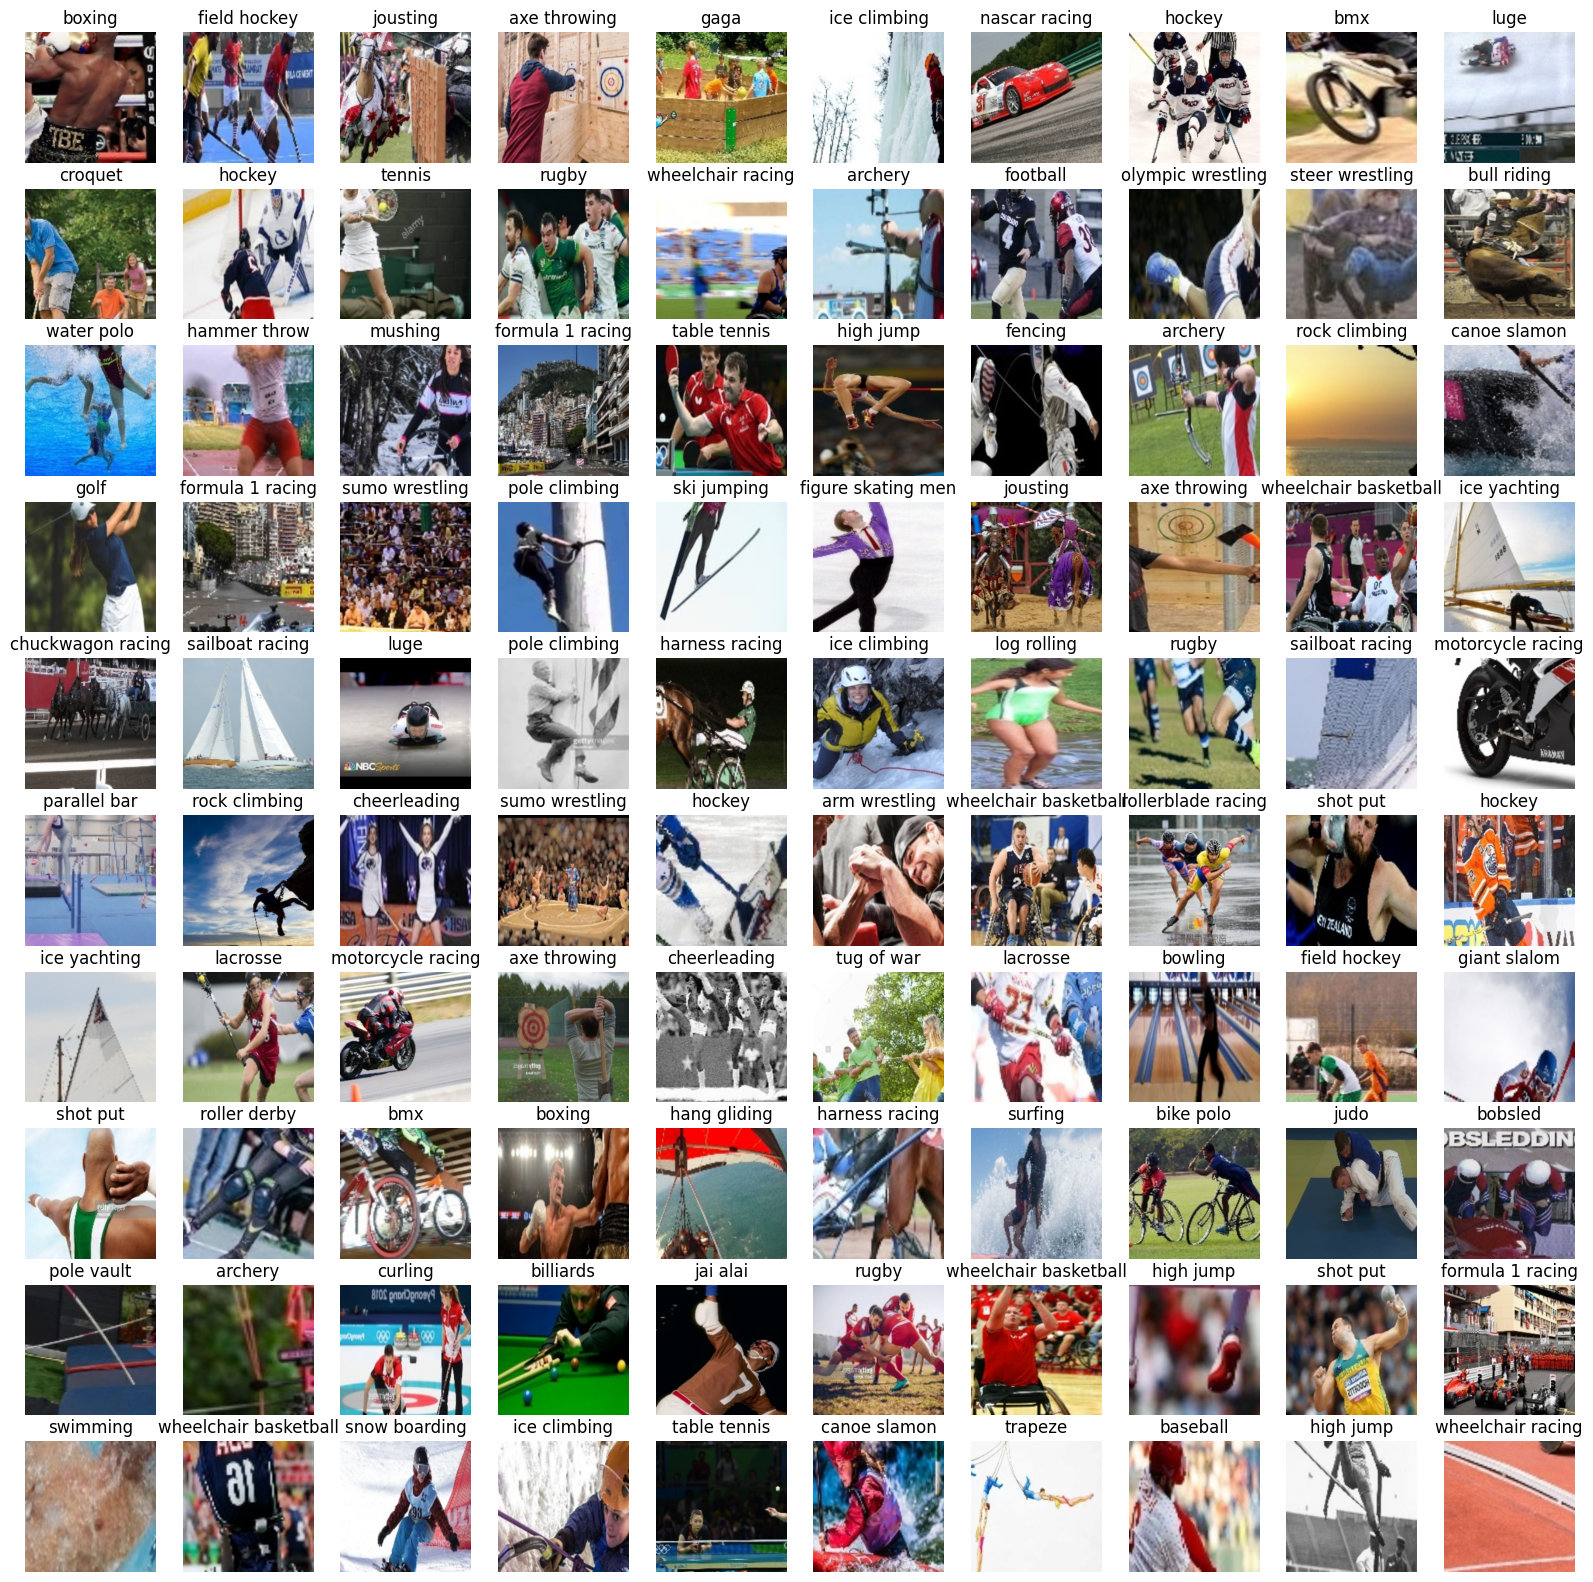

In [11]:
display_images(train_loader, train_data.classes)

## Trainig Loop

In [11]:
def train_loop(n_epochs, model, optimizer, criterion, train_loader, scheduler = None):
    import datetime
    val_losses = []
    train_losses = []
    val_accuracies = []
    train_accuracies = []
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
        if scheduler:
            scheduler.step()
            
            
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total_predictions += labels.size(0)
                val_correct_predictions += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for validation
        val_loss = val_running_loss / len(val_loader)
        val_accuracy = 100 * val_correct_predictions / val_total_predictions
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch [{epoch+1}/{n_epochs}], '+
              f'Train_Loss: {train_loss:.3f}, ' +
              f'Train_Accuracy: {train_accuracy:.2f}, '+
              f'Val_Loss: {val_loss:.3f}, '+
              f'Val_Accuracy: {val_accuracy:.2f}')
    return [train_accuracies, train_losses, val_accuracies, val_losses]

## Validation Loop

In [12]:
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

# AlexNet

Load AlexNet as pre-trained model

In [19]:
model = models.alexnet(pretrained = True)

## Modifiy last layer of the model

In order to implement transfer learning we need to modeify the last layer of the AlexNet. So instead of 1000 classes we have 100 classes, now modify for it.

In [20]:
num_classes = len(train_data.classes)
for param in model.features.parameters():
    param.requires_grad = False
for parm in model.features[-3].parameters():
    param.requires_grad = True
    
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send Model to device

In [21]:
model = model.to(device = device)

## Define Loss Function and Optimizer

In [22]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## Train the model

In [23]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 2.374, Train_Accuracy: 40.79, Val_Loss: 1.037, Val_Accuracy: 70.4514363885089
Epoch [2/15], Train_Loss: 1.450, Train_Accuracy: 59.89, Val_Loss: 0.859, Val_Accuracy: 74.92020063839489
Epoch [3/15], Train_Loss: 1.248, Train_Accuracy: 65.41, Val_Loss: 0.781, Val_Accuracy: 77.9297765617875
Epoch [4/15], Train_Loss: 1.132, Train_Accuracy: 67.74, Val_Loss: 0.743, Val_Accuracy: 78.3857729138167
Epoch [5/15], Train_Loss: 1.042, Train_Accuracy: 70.80, Val_Loss: 0.700, Val_Accuracy: 79.25216598267214
Epoch [6/15], Train_Loss: 0.962, Train_Accuracy: 72.61, Val_Loss: 0.718, Val_Accuracy: 79.98176014591883
Epoch [7/15], Train_Loss: 0.923, Train_Accuracy: 73.78, Val_Loss: 0.696, Val_Accuracy: 80.30095759233926
Epoch [8/15], Train_Loss: 0.868, Train_Accuracy: 74.93, Val_Loss: 0.717, Val_Accuracy: 79.89056087551299
Epoch [9/15], Train_Loss: 0.824, Train_Accuracy: 76.13, Val_Loss: 0.673, Val_Accuracy: 80.75695394436845
Epoch [10/15], Train_Loss: 0.800, Train_Accuracy: 77.24, V

## Plot the Graphs

In [24]:
train_accuracies, train_losses, val_accuracies, val_losses = history

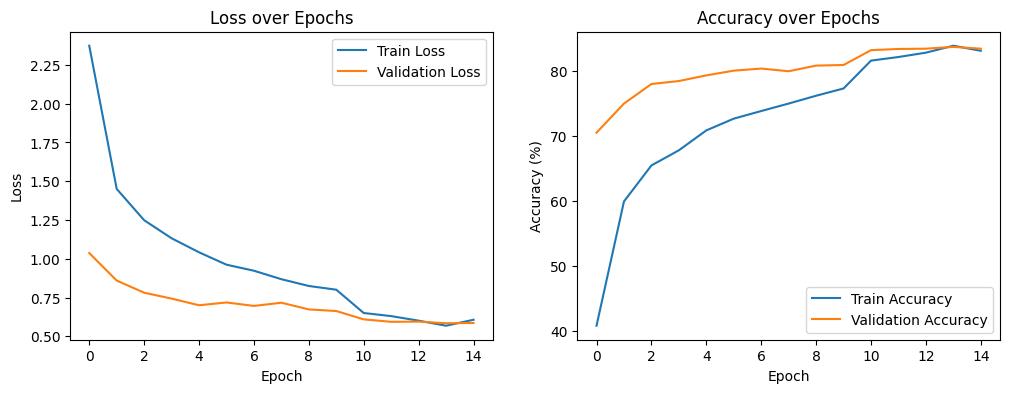

In [25]:
# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy over Epochs")

plt.show()

## Validate the model

In [27]:
import collections
all_acc_dict = collections.OrderedDict()

all_acc_dict['AlexNet'] = validate(model, train_loader, test_loader)

Accuracy train: 0.89
Accuracy val: 0.82


# VGGNET

## VGG16

Load VGG16 as pre-trained model

In [28]:
model = models.vgg16(weights = models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 208MB/s]  


## Modify Last Layer of the model

In [29]:
for param in model.features.parameters():
    param.requires_grad = False
    
    
for param in model.classifier[-2].parameters():
    param.requires_grad = True

# for param in model.features[-10:].parameters():  # Last two convolutional layers
#     param.requires_grad = True
    
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send Model to device

In [30]:
model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

Using 2 GPUs


## Define Loss Function and Optimization

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## Train the model

In [32]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/15], Train_Loss: 2.209, Train_Accuracy: 44.58, Val_Loss: 0.659, Val_Accuracy: 81.21295029639762
Epoch [2/15], Train_Loss: 1.230, Train_Accuracy: 65.70, Val_Loss: 0.504, Val_Accuracy: 83.72093023255815
Epoch [3/15], Train_Loss: 1.005, Train_Accuracy: 71.67, Val_Loss: 0.480, Val_Accuracy: 85.8641130870953
Epoch [4/15], Train_Loss: 0.910, Train_Accuracy: 74.24, Val_Loss: 0.457, Val_Accuracy: 86.54810761513907
Epoch [5/15], Train_Loss: 0.842, Train_Accuracy: 76.18, Val_Loss: 0.452, Val_Accuracy: 86.68490652074783
Epoch [6/15], Train_Loss: 0.787, Train_Accuracy: 77.95, Val_Loss: 0.425, Val_Accuracy: 87.50569995440037
Epoch [7/15], Train_Loss: 0.743, Train_Accuracy: 79.17, Val_Loss: 0.415, Val_Accuracy: 88.60009119927041
Epoch [8/15], Train_Loss: 0.726, Train_Accuracy: 79.60, Val_Loss: 0.383, Val_Accuracy: 89.37528499772002
Epoch [9/15], Train_Loss: 0.680, Train_Accuracy: 80.25, Val_Loss: 0.396, Val_Accuracy: 89.51208390332877
Epoch [10/15], Train_Loss: 0.628, Train_Accuracy: 82.23,

## Plot the Graphs

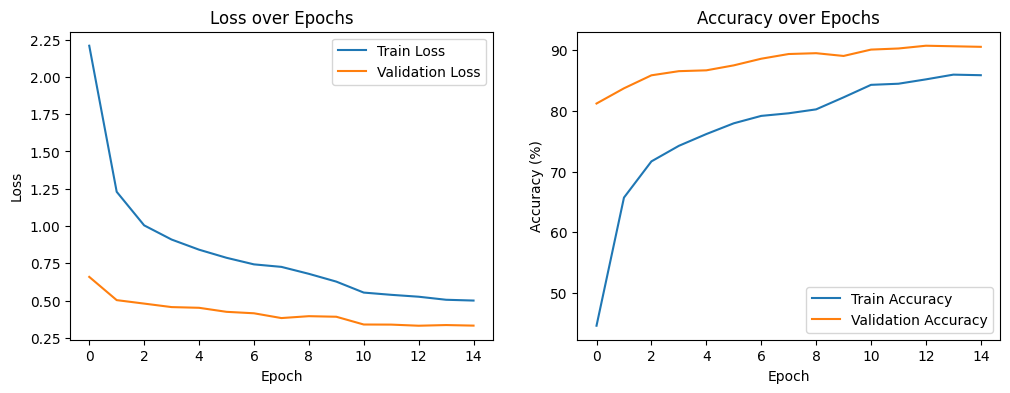

In [33]:
show_results(history)

## Validate the model

In [34]:
all_acc_dict['VGG16'] = validate(model, train_loader, test_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Accuracy train: 0.89
Accuracy val: 0.90


## VGG19
Load VGG19 as pre-trained model

In [14]:
model = models.vgg19(weights = models.VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 218MB/s]  


In [36]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Modify Last layer of the model

In [15]:
for param in model.parameters():
    param.requires_grad = False
for param in model.features[32:].parameters():
    param.requires_grad = True
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

## Send model to device

In [16]:
model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs')
    model = nn.DataParallel(model)

Using 2 GPUs


## Define Loss Function and Optimization

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## Train the model

In [18]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch [1/15], Train_Loss: 2.417, Train_Accuracy: 38.60, Val_Loss: 0.804, Val_Accuracy: 77.38258093935248
Epoch [2/15], Train_Loss: 1.299, Train_Accuracy: 63.74, Val_Loss: 0.574, Val_Accuracy: 83.40173278613771
Epoch [3/15], Train_Loss: 1.039, Train_Accuracy: 70.06, Val_Loss: 0.452, Val_Accuracy: 87.0953032375741
Epoch [4/15], Train_Loss: 0.909, Train_Accuracy: 73.95, Val_Loss: 0.437, Val_Accuracy: 87.27770177838578
Epoch [5/15], Train_Loss: 0.819, Train_Accuracy: 76.23, Val_Loss: 0.403, Val_Accuracy: 88.37209302325581
Epoch [6/15], Train_Loss: 0.768, Train_Accuracy: 77.95, Val_Loss: 0.379, Val_Accuracy: 88.73689010487917
Epoch [7/15], Train_Loss: 0.717, Train_Accuracy: 79.36, Val_Loss: 0.338, Val_Accuracy: 89.96808025535796
Epoch [8/15], Train_Loss: 0.646, Train_Accuracy: 81.10, Val_Loss: 0.345, Val_Accuracy: 90.24167806657547
Epoch [9/15], Train_Loss: 0.609, Train_Accuracy: 82.39, Val_Loss: 0.323, Val_Accuracy: 90.3328773369813
Epoch [10/15], Train_Loss: 0.611, Train_Accuracy: 82.53, 

In [19]:
all_acc_dict['VGG19'] = validate(model, train_loader, test_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Accuracy train: 0.90
Accuracy val: 0.92


NameError: name 'all_acc_dict' is not defined

## Plot the Results

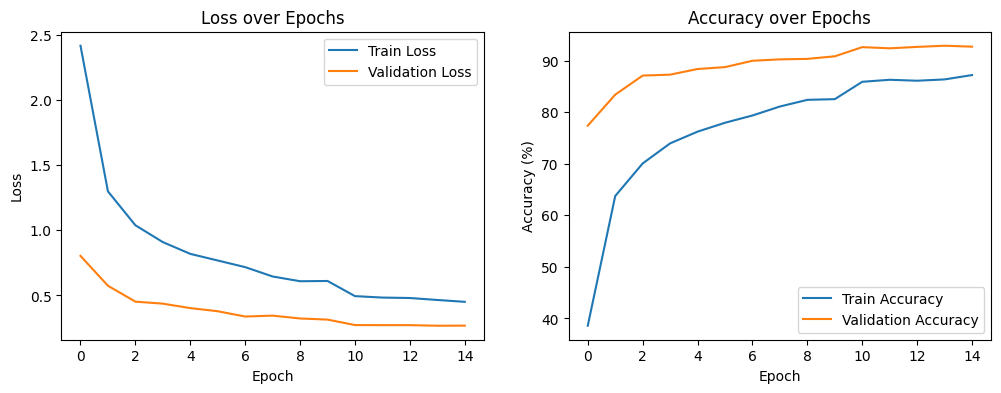

In [20]:
show_results(history)

In [24]:
from PIL import Image
image = Image.open('/kaggle/input/dataset/cricket.jpg')
image = val_transforms(image).unsqueeze(0)

cricket


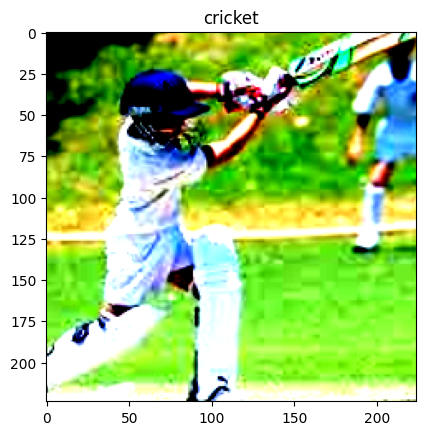

In [25]:
labels = train_data.classes
model.eval()
with torch.no_grad():
    image = image.to(device)
    output = model(image)
    _, predicted = torch.max(output, 1)
    predict_class = predicted.item()
print(labels[predict_class])
img = image.to(device = 'cpu')
plt.imshow(img[0].permute(1,2,0))
plt.title(labels[predict_class])
plt.show()

# GoogLeNet (Inception v1)

In [26]:
model = models.googlenet(weights = models.GoogLeNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 52.0MB/s]


## Modify Last Layers of the model

In PyTorch, the GoogLeNet model indeed does not have an attribute called classifier, unlike models such as AlexNet or VGG. Instead, GoogLeNet uses an attribute called fc for its fully connected layer, which is the final classification layer in the architecture.

In [28]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Send model to device

In [29]:
model = model.to(device)

## Define Loss Function and Optimizer

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## Train the model

In [31]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 4.402, Train_Accuracy: 8.01, Val_Loss: 4.077, Val_Accuracy: 28.590971272229822
Epoch [2/15], Train_Loss: 3.984, Train_Accuracy: 25.44, Val_Loss: 3.626, Val_Accuracy: 44.824441404468764
Epoch [3/15], Train_Loss: 3.632, Train_Accuracy: 39.32, Val_Loss: 3.241, Val_Accuracy: 56.8171454628363
Epoch [4/15], Train_Loss: 3.316, Train_Accuracy: 47.52, Val_Loss: 2.898, Val_Accuracy: 63.70269037847697
Epoch [5/15], Train_Loss: 3.044, Train_Accuracy: 53.36, Val_Loss: 2.620, Val_Accuracy: 66.484268125855
Epoch [6/15], Train_Loss: 2.825, Train_Accuracy: 56.24, Val_Loss: 2.354, Val_Accuracy: 70.36023711810306
Epoch [7/15], Train_Loss: 2.620, Train_Accuracy: 58.97, Val_Loss: 2.166, Val_Accuracy: 71.68262653898769
Epoch [8/15], Train_Loss: 2.464, Train_Accuracy: 59.83, Val_Loss: 1.997, Val_Accuracy: 73.55221158230734
Epoch [9/15], Train_Loss: 2.324, Train_Accuracy: 62.21, Val_Loss: 1.849, Val_Accuracy: 74.78340173278613
Epoch [10/15], Train_Loss: 2.199, Train_Accuracy: 62.72, 

## Validate the model

In [32]:
validate(model, train_loader, test_loader)

Accuracy train: 0.69
Accuracy val: 0.77


{'train': 0.693136349646045, 'val': 0.7655945419103314}

## Plotting Resluts

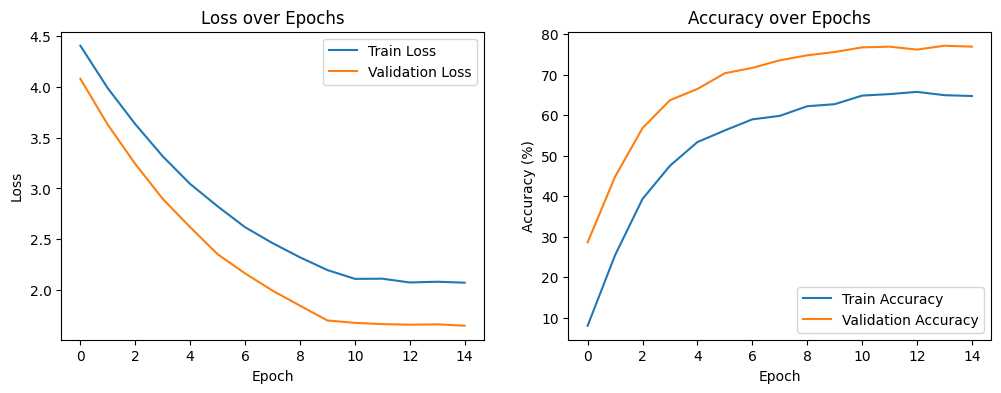

In [33]:
show_results(history)

# ResNet

## ResNet50

In [29]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

## Modify Last Layer

In [30]:
for param in model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if "layer4.2.conv3" in name:
        param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Send model to device

In [31]:
model = model.to(device)

## Define Loss Function and Optimizer

In [32]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size = 10, gamma=0.1)

## Train the Model

In [33]:
history = train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 2.062, Train_Accuracy: 53.59, Val_Loss: 0.716, Val_Accuracy: 82.44
Epoch [2/15], Train_Loss: 1.020, Train_Accuracy: 73.82, Val_Loss: 0.539, Val_Accuracy: 85.36
Epoch [3/15], Train_Loss: 0.805, Train_Accuracy: 79.44, Val_Loss: 0.461, Val_Accuracy: 87.68
Epoch [4/15], Train_Loss: 0.714, Train_Accuracy: 81.20, Val_Loss: 0.399, Val_Accuracy: 89.32
Epoch [5/15], Train_Loss: 0.632, Train_Accuracy: 83.54, Val_Loss: 0.370, Val_Accuracy: 89.01
Epoch [6/15], Train_Loss: 0.572, Train_Accuracy: 85.02, Val_Loss: 0.339, Val_Accuracy: 90.10
Epoch [7/15], Train_Loss: 0.540, Train_Accuracy: 86.05, Val_Loss: 0.322, Val_Accuracy: 90.88
Epoch [8/15], Train_Loss: 0.501, Train_Accuracy: 86.96, Val_Loss: 0.306, Val_Accuracy: 91.10
Epoch [9/15], Train_Loss: 0.461, Train_Accuracy: 88.01, Val_Loss: 0.293, Val_Accuracy: 91.74
Epoch [10/15], Train_Loss: 0.425, Train_Accuracy: 88.93, Val_Loss: 0.309, Val_Accuracy: 91.42
Epoch [11/15], Train_Loss: 0.395, Train_Accuracy: 89.58, Val_Loss: 0.

## Validate the Model

In [34]:
validate(model, train_loader, test_loader)

Accuracy train: 0.93
Accuracy val: 0.93


{'train': 0.9252154288059089, 'val': 0.9293372319688109}

## Plot Results

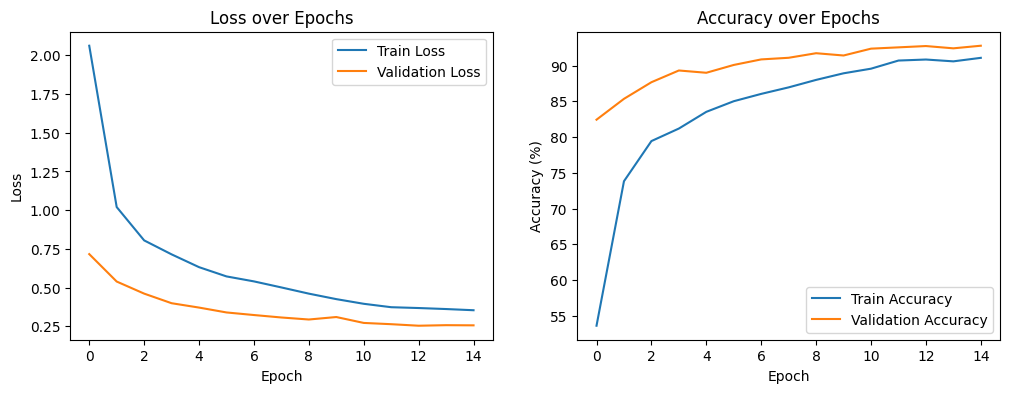

In [35]:
show_results(history)

## ResNet101

In [36]:
model = models.resnet101(weights = models.ResNet101_Weights.DEFAULT)

## Modify Layers of Model

In [37]:
for name, param in model.named_parameters():
    if 'layer4' in name:  # layer4 is the last block of ResNet-101
        param.requires_grad = True
    else:
        param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

## Send Model to Device

In [38]:
model = model.to(device)

## Define Loss and Optimizer

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)
scheduler = StepLR(optimizer, step_size = 10, gamma = 0.1)

## Train the model

In [40]:
train_loop(
    n_epochs = 15,
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    train_loader = train_loader,
    scheduler = scheduler
)

Epoch [1/15], Train_Loss: 1.496, Train_Accuracy: 61.82, Val_Loss: 0.423, Val_Accuracy: 86.95
Epoch [2/15], Train_Loss: 0.615, Train_Accuracy: 83.03, Val_Loss: 0.295, Val_Accuracy: 91.01
Epoch [3/15], Train_Loss: 0.450, Train_Accuracy: 87.38, Val_Loss: 0.259, Val_Accuracy: 92.97
Epoch [4/15], Train_Loss: 0.414, Train_Accuracy: 88.13, Val_Loss: 0.234, Val_Accuracy: 93.34
Epoch [5/15], Train_Loss: 0.319, Train_Accuracy: 90.66, Val_Loss: 0.215, Val_Accuracy: 93.66
Epoch [6/15], Train_Loss: 0.304, Train_Accuracy: 91.52, Val_Loss: 0.202, Val_Accuracy: 94.66
Epoch [7/15], Train_Loss: 0.281, Train_Accuracy: 92.19, Val_Loss: 0.193, Val_Accuracy: 94.11
Epoch [8/15], Train_Loss: 0.259, Train_Accuracy: 92.58, Val_Loss: 0.200, Val_Accuracy: 94.62
Epoch [9/15], Train_Loss: 0.251, Train_Accuracy: 92.97, Val_Loss: 0.217, Val_Accuracy: 94.21
Epoch [10/15], Train_Loss: 0.240, Train_Accuracy: 92.97, Val_Loss: 0.209, Val_Accuracy: 94.30
Epoch [11/15], Train_Loss: 0.186, Train_Accuracy: 94.84, Val_Loss: 0.

[[61.81780878128847,
  83.03241690603201,
  87.38202708247846,
  88.13089864587607,
  90.66475174394748,
  91.516208453016,
  92.19327041444399,
  92.58309396799343,
  92.97291752154288,
  92.97291752154288,
  94.83996717275339,
  95.66064833812064,
  95.64013130898645,
  96.10176446450554,
  96.20434961017645],
 [1.4963161317051434,
  0.6148287740642907,
  0.449590947735505,
  0.414253644999422,
  0.318962222007943,
  0.3044012455544511,
  0.28057367554331414,
  0.25869210730993847,
  0.25104067391548,
  0.23960979710348318,
  0.1855840077623725,
  0.1623190294706919,
  0.15156310413063306,
  0.14454739864182764,
  0.13351167161552022],
 [86.95255474452554,
  91.01277372262774,
  92.97445255474453,
  93.33941605839416,
  93.6587591240876,
  94.66240875912409,
  94.11496350364963,
  94.61678832116789,
  94.20620437956204,
  94.29744525547446,
  95.57481751824818,
  95.8485401459854,
  95.8029197080292,
  95.8029197080292,
  96.07664233576642],
 [0.42320261930749903,
  0.29473581822147,

In [41]:
validate(model, train_loader, test_loader)

Accuracy train: 0.97
Accuracy val: 0.96


{'train': 0.9688141157160444, 'val': 0.9610136452241715}